In [0]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil,floor
model_root_dir = '/content/'
from tensorflow.examples.tutorials.mnist import input_data

In [0]:
image_dims = (28,28)
input_size = 28**2
num_classes = 10

In [0]:
class classifier():
    
    def __init__(self, layers):
        
        self.mnist = input_data.read_data_sets(model_root_dir+'MNIST_data', one_hot=True)
        
        layers += [num_classes]
        self.layers = layers
        
        self._init_weights()
        self._init_biases()
        
    def _init_weights(self):
        
        self.Weights = []

        for layer in self.layers:

            if len(self.Weights) == 0:
                self.Weights += [np.random.randn(input_size,layer)]

            else:
                self.Weights += [np.random.randn(self.Weights[-1].shape[-1],layer)]
                
    def _init_biases(self):
        
        self.biases = []
        
        for layer in self.layers:
            
            self.biases += [np.random.randn(layer)]
            
            
            
            
    def activation(self,x):
        
        x[x<0] = 0.0
        
        return(x)
    
    def activation_prime(self,x):
        
        x[x<0] = 0.0
        x[x>0] = 1.0
        
        return(x)
        
        
        
        
    def forward_pass(self,x):
        
        inputs_to_layers = []
        inputs_to_activations = []
        
        for layer in range(len(self.layers)):
            
            inputs_to_layers += [x]
            
            x = np.matmul(x,self.Weights[layer]) + self.biases[layer]
            
            if layer+1 != len(self.layers):
                
                inputs_to_activations += [x]
                
                x = self.activation(x)

        return(x,inputs_to_layers,inputs_to_activations)
    
    
    
    def softmax(self,x):
        
        x = x - np.max(x,axis=1,keepdims=True)
        
        output = np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        
        return(output)
    
    
    
    def cross_entropy(self,labels,logits):

        labels = labels.reshape(-1,num_classes)
        logits = logits.reshape(-1,num_classes)
        
        losses = -np.sum(labels*np.log(np.clip(logits,1e-10,1)), axis=1)

        loss = np.mean(losses)

        return(loss)
    
    
    
    def back_prop(self,softmax_outputs,labels,learning_rate,layer_inputs,activation_inputs):

        batch_size = labels.shape[0]

        grads = softmax_outputs - labels
        
        for layer in range(len(self.layers)-1,-1,-1):
            
            if layer != len(self.layers)-1:
                
                grads = grads*self.activation_prime(activation_inputs[layer])

            W_deltas = np.matmul(layer_inputs[layer].transpose(),grads)
            b_deltas = np.sum(grads,axis=0)
            
            grads = np.matmul(grads,self.Weights[layer].transpose())
            
            W_deltas /= batch_size
            b_deltas /= batch_size
            
            self.Weights[layer] -= learning_rate*W_deltas
            self.biases[layer] -= learning_rate*b_deltas
            
            
            
            
    def calculate_accuracy(self,dataset):
        
        logits = self.forward_pass(dataset.images)[0]
        labels = dataset.labels
        
        marking = np.equal(np.argmax(logits,axis=1),np.argmax(labels,axis=1))
        return(np.mean(marking.astype(np.int32)))
    
    
    
    
    def train(self,batch_size,learning_rate,epochs,reset):
        
        if reset == True:
            self._init_weights()
            self._init_biases()
        
        self.losses = np.array([])

        iterations = int(ceil(float(self.mnist.train.num_examples)/batch_size))

        for epoch in range(epochs):
            print('New epoch', str(epoch+1)+'/'+str(epochs))
            for iteration in range(iterations):

                X = self.mnist.train.images[iteration*batch_size:(iteration+1)*batch_size]
                Y = self.mnist.train.labels[iteration*batch_size:(iteration+1)*batch_size]

                nn_out,layer_inputs,activation_inputs = self.forward_pass(X)
                soft_out = self.softmax(nn_out)
                ce_out = self.cross_entropy(Y,soft_out)

                self.back_prop(soft_out,Y,learning_rate,layer_inputs,activation_inputs)

                if (iteration+1) % floor(iterations/5) == 0:

                    accuracy = self.calculate_accuracy(self.mnist.validation)

                    print('step', str(iteration+1)+'/'+str(iterations), 'loss', ce_out, 'accuracy', str(round(100*accuracy,2))+'%')

                self.losses = np.append(self.losses, ce_out)
                
    def plot_losses(self):
        fig, ax = plt.subplots(figsize=(10,6))
        ax.plot(self.losses)
        ax.grid(True)

In [7]:
Model = classifier(layers=[256])

Extracting /content/MNIST_data/train-images-idx3-ubyte.gz
Extracting /content/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /content/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /content/MNIST_data/t10k-labels-idx1-ubyte.gz


New epoch 1/2
step 110/550 loss 2.4225003625566406 accuracy 84.96%
step 220/550 loss 1.1162489081698501 accuracy 87.64%
step 330/550 loss 1.4707423573151488 accuracy 90.26%
step 440/550 loss 2.190449153809702 accuracy 89.92%
step 550/550 loss 1.3537596459410162 accuracy 90.68%
New epoch 2/2
step 110/550 loss 1.2762387152566266 accuracy 91.28%
step 220/550 loss 0.3842534309075649 accuracy 91.5%
step 330/550 loss 0.8623617258332844 accuracy 92.18%
step 440/550 loss 1.0565260450598284 accuracy 91.76%
step 550/550 loss 0.9719025180008191 accuracy 92.52%
92.08


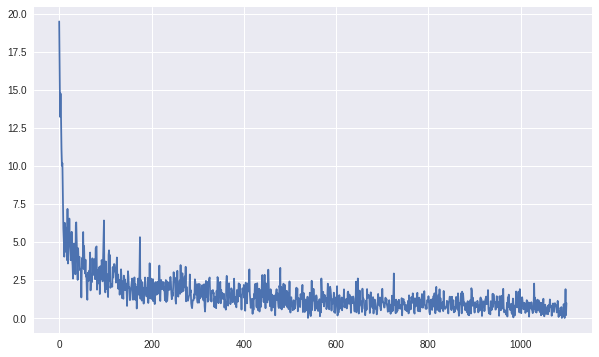

In [8]:
Model.train(batch_size=100,
            learning_rate=0.2,
            epochs=2,
            reset=True)
Model.plot_losses()
print(100*Model.calculate_accuracy(Model.mnist.test))